# Basis for grayscale images

## Introduction

Consider the set of real-valued matrices of size $M\times N$; we can turn this into a vector space by defining addition and scalar multiplication in the usual way:

\begin{align}
\mathbf{A} + \mathbf{B} &=  
    \left[ 
        \begin{array}{ccc} 
            a_{0,0} & \dots & a_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            a_{M-1,0} & \dots & b_{M-1,N-1} 
        \end{array}
    \right]
    + 
    \left[ 
        \begin{array}{ccc} 
            b_{0,0} & \dots & b_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            b_{M-1,0} & \dots & b_{M-1,N-1} 
        \end{array}
    \right]
    \\
    &=
    \left[ 
        \begin{array}{ccc} 
            a_{0,0}+b_{0,0} & \dots & a_{0,N-1}+b_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            a_{M-1,0}+b_{M-1,0} & \dots & a_{M-1,N-1}+b_{M-1,N-1} 
        \end{array}
    \right]     
    \\ \\ \\
\beta\mathbf{A} &=  
    \left[ 
        \begin{array}{ccc} 
            \beta a_{0,0} & \dots & \beta a_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            \beta a_{M-1,0} & \dots & \beta a_{M-1,N-1}
        \end{array}
    \right]
\end{align}


As a matter of fact, the space of real-valued $M\times N$ matrices is completely equivalent to $\mathbb{R}^{MN}$ and we can always "unroll" a matrix into a vector. Assume we proceed column by column; then the matrix becomes

$$
    \mathbf{a} = \mathbf{A}[:] = [
        \begin{array}{ccccccc}
            a_{0,0} & \dots & a_{M-1,0} & a_{0,1} & \dots & a_{M-1,1} & \ldots & a_{0, N-1} & \dots & a_{M-1,N-1}
        \end{array}]^T
$$

Although the matrix and vector forms represent exactly the same data, the matrix form allows us to display the data in the form of an image. Assume each value in the matrix is a grayscale intensity, where zero is black and 255 is white; for example we can create a checkerboard pattern of any size with the following function:

In [1]:
# usual pyton bookkeeping...
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import Image
import math

In [2]:
# ensure all images will be grayscale
plt.gray();

<Figure size 432x288 with 0 Axes>

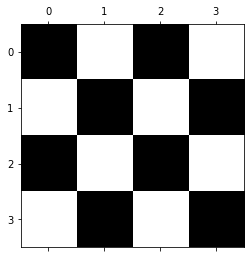

In [3]:
# let's create a checkerboard pattern
SIZE = 4
img = np.zeros((SIZE, SIZE))
for n in range(0, SIZE):
    for m in range(0, SIZE):
        if (n & 0x1) ^ (m & 0x1):
            img[n, m] = 255

# now display the matrix as an image
plt.matshow(img); 

Given the equivalence between the space of $M\times N$ matrices and $\mathbb{R}^{MN}$ we can easily define the inner product between two matrices in the usual way:

$$
\langle \mathbf{A}, \mathbf{B} \rangle = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} a_{m,n} b_{m, n}
$$

(where we have neglected the conjugation since we'll only deal with real-valued matrices); in other words, we can take the inner product between two matrices as the standard inner product of their unrolled versions. The inner product allows us to define orthogonality between images and this is rather useful since we're going to explore a couple of bases for this space.


## Actual images

Conveniently, using IPython, we can read images from disk in any given format and convert them to numpy arrays; let's load and display for instance a JPEG image:

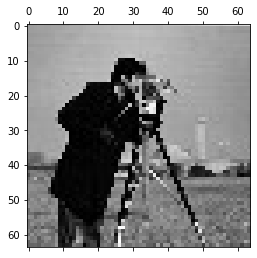

In [4]:
img = np.array(plt.imread('cameraman.jpg'), dtype=int)
plt.matshow(img);

The image is a $64\times 64$ low-resolution version of the famous "cameraman" test picture. Out of curiosity, we can look at the first column of this image, which is is a $64×1$ vector:

In [5]:
img[:,0]

array([156, 157, 157, 152, 154, 155, 151, 157, 152, 155, 158, 159, 159,
       160, 160, 161, 155, 160, 161, 161, 164, 162, 160, 162, 158, 160,
       158, 157, 160, 160, 159, 158, 163, 162, 162, 157, 160, 114, 114,
       103,  88,  62, 109,  82, 108, 128, 138, 140, 136, 128, 122, 137,
       147, 114, 114, 144, 112, 115, 117, 131, 112, 141,  99,  97])

The values are integers between zero and 255, meaning that each pixel is encoded over 8 bits (or 256 gray levels).

## The canonical basis

The canonical basis for any matrix space $\mathbb{R}^{M\times N}$ is the set of "delta" matrices where only one element equals to one while all the others are 0. Let's call them $\mathbf{E}_n$ with $0 \leq n < MN$. Here is a function to create the canonical basis vector given its index:

In [6]:
def canonical(n, M=5, N=10):
    e = np.zeros((M, N))
    e[(n % M), int(n / M)] = 1
    return e

Here are some basis vectors: look for the position of white pixel, which differentiates them and note that we enumerate pixels column-wise:

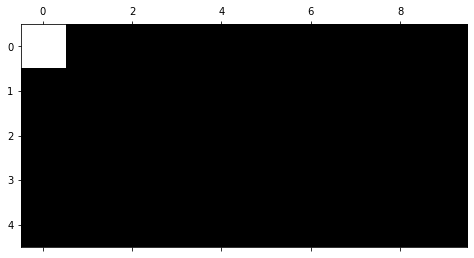

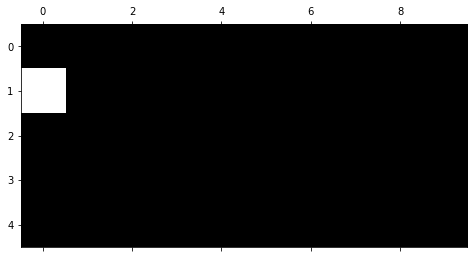

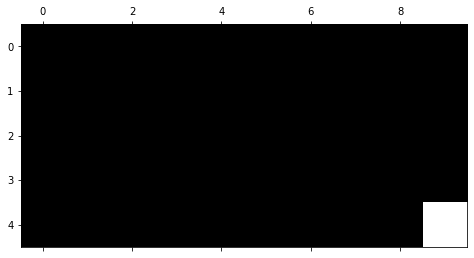

In [7]:
plt.matshow(canonical(0));
plt.matshow(canonical(1));
plt.matshow(canonical(49));

## Transmitting images

Suppose we want to transmit the "cameraman" image over a communication channel. The intuitive way to do so is to send the  pixel values one by one, which corresponds to sending the coefficients of the decomposition of the image over the canonical basis. So far, nothing complicated: to send the cameraman image, for instance, we will send $64\times 64 = 4096$ coefficients in a row. 

Now suppose that a communication failure takes place after the first half of the pixels have been sent. The received data will allow us to display an approximation of the original image only. If we replace the missing data with zeros, here is what we would see, which is not very pretty:

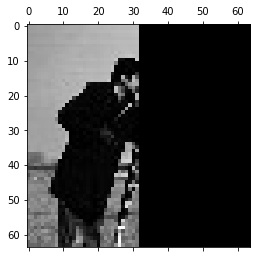

In [8]:
# unrolling of the image for transmission (we go column by column, hence "F")
tx_img = np.ravel(img, "F")

# oops, we lose half the data
tx_img[int(len(tx_img)/2):] = 0

# rebuild matrix
rx_img = np.reshape(tx_img, (64, 64), "F")
plt.matshow(rx_img);

Can we come up with a trasmission scheme that is more robust in the face of channel loss? Interestingly, the answer is yes, and it involves a different, more versatile basis for the space of images. What we will do is the following: 

* describe the Haar basis, a new basis for the image space
* project the image in the new basis
* transmit the projection coefficients
* rebuild the image using the basis vectors

We know a few things: if we choose an orthonormal basis, the analysis and synthesis formulas will be super easy (a simple inner product and a scalar multiplication respectively). The trick is to find a basis that will be robust to the loss of some coefficients. 

One such basis is the **Haar basis**. We cannot go into too many details in this notebook but, for the curious, a good starting point is [here](https://chengtsolin.wordpress.com/2015/04/15/real-time-2d-discrete-wavelet-transform-using-opengl-compute-shader/). Mathematical formulas aside, the Haar basis works by encoding the information in a *hierarchical* way: the first basis vectors encode the broad information and the higher coefficients encode the detail. Let's have a look. 

First of all, to keep things simple, we will remain in the space of square matrices whose size is a power of two. The code to generate the Haar basis matrices is the following: first we generate a 1D Haar vector and then we obtain the basis matrices by taking the outer product of all possible 1D vectors (don't worry if it's not clear, the results are what's important):

In [9]:
def haar1D(n, SIZE):
    # check power of two
    if math.floor(math.log(SIZE) / math.log(2)) != math.log(SIZE) / math.log(2):
        print("Haar defined only for lengths that are a power of two")
        return None
    if n >= SIZE or n < 0:
        print("invalid Haar index")
        return None
    
    # zero basis vector
    if n == 0:
        return np.ones(SIZE)
    
    # express n > 1 as 2^p + q with p as large as possible;
    # then k = SIZE/2^p is the length of the support
    # and s = qk is the shift
    p = math.floor(math.log(n) / math.log(2))
    pp = int(pow(2, p))
    k = SIZE / pp
    s = (n - pp) * k
    
    h = np.zeros(SIZE)
    h[int(s):int(s+k/2)] = 1
    h[int(s+k/2):int(s+k)] = -1
    # these are not normalized
    return h


def haar2D(n, SIZE=8):
    # get horizontal and vertical indices
    hr = haar1D(n % SIZE, SIZE)
    hv = haar1D(int(n / SIZE), SIZE)
    # 2D Haar basis matrix is separable, so we can
    #  just take the column-row product
    H = np.outer(hr, hv)
    H = H / math.sqrt(np.sum(H * H))
    return H

First of all, let's look at a few basis matrices; note that the matrices have positive and negative values, so that the value of zero will be represented as gray:

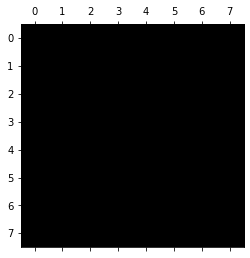

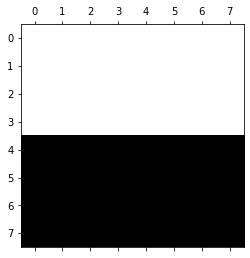

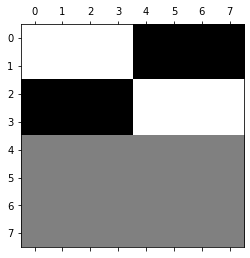

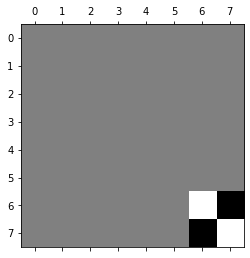

In [10]:
plt.matshow(haar2D(0));
plt.matshow(haar2D(1));
plt.matshow(haar2D(10));
plt.matshow(haar2D(63));

We can notice two key properties

* each basis matrix has positive and negative values in some symmetric patter: this means that the basis matrix will implicitly compute the difference between image areas
* low-index basis matrices take differences between large areas, while high-index ones take differences in smaller **localized** areas of the image

We can immediately verify that the Haar matrices are orthogonal:

In [11]:
# let's use an 8x8 space; there will be 64 basis vectors
# compute all possible inner product and only print the nonzero results
for m in range(0,64):
    for n in range(0,64):
        r = np.sum(haar2D(m, 8) * haar2D(n, 8))
        if r != 0:
            print("[%dx%d -> %f] " % (m, n, r), end="")

[0x0 -> 1.000000] [1x1 -> 1.000000] [2x2 -> 1.000000] [3x3 -> 1.000000] [4x4 -> 1.000000] [5x5 -> 1.000000] [6x6 -> 1.000000] [7x7 -> 1.000000] [8x8 -> 1.000000] [9x9 -> 1.000000] [10x10 -> 1.000000] [11x11 -> 1.000000] [12x12 -> 1.000000] [13x13 -> 1.000000] [14x14 -> 1.000000] [15x15 -> 1.000000] [16x16 -> 1.000000] [16x17 -> -0.000000] [17x16 -> -0.000000] [17x17 -> 1.000000] [18x18 -> 1.000000] [19x19 -> 1.000000] [20x20 -> 1.000000] [21x21 -> 1.000000] [22x22 -> 1.000000] [23x23 -> 1.000000] [24x24 -> 1.000000] [24x25 -> -0.000000] [25x24 -> -0.000000] [25x25 -> 1.000000] [26x26 -> 1.000000] [27x27 -> 1.000000] [28x28 -> 1.000000] [29x29 -> 1.000000] [30x30 -> 1.000000] [31x31 -> 1.000000] [32x32 -> 1.000000] [33x33 -> 1.000000] [34x34 -> 1.000000] [35x35 -> 1.000000] [36x36 -> 1.000000] [37x37 -> 1.000000] [38x38 -> 1.000000] [39x39 -> 1.000000] [40x40 -> 1.000000] [41x41 -> 1.000000] [42x42 -> 1.000000] [43x43 -> 1.000000] [44x44 -> 1.000000] [45x45 -> 1.000000] [46x46 -> 1.0000

OK! Everything's fine. Now let's transmit the "cameraman" image: first, let's verify that it works

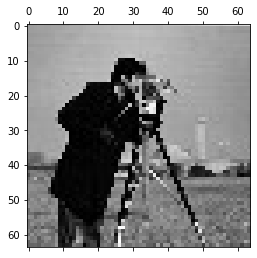

In [12]:
# project the image onto the Haar basis, obtaining a vector of 4096 coefficients
# this is simply the analysis formula for the vector space with an orthogonal basis
tx_img = np.zeros(64*64)
for k in range(0, (64*64)):
    tx_img[k] = np.sum(img * haar2D(k, 64))

# now rebuild the image with the synthesis formula; since the basis is orthonormal
#  we just need to scale the basis matrices by the projection coefficients
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += tx_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

Cool, it works! Now let's see what happens if we lose the second half of the coefficients:

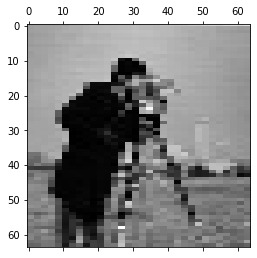

In [13]:
# oops, we lose half the data
lossy_img = np.copy(tx_img);
lossy_img[int(len(tx_img)/2):] = 0

# rebuild matrix
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += lossy_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

That's quite remarkable, no? We've lost the same amount of information as before but the image is still acceptable. This is because we lost the coefficients associated to the fine details of the image but we retained the "broad strokes" encoded by the first half. 

Note that if we lose the first half of the coefficients the result is markedly different:

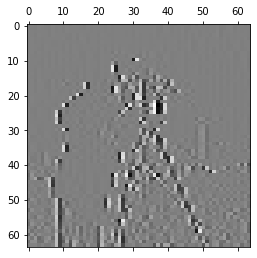

In [14]:
lossy_img = np.copy(tx_img);
lossy_img[0:int(len(tx_img)/2)] = 0

rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += lossy_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

In fact, schemes like this one are used in *progressive encoding*: send the most important information first and add details if the channel permits it. You may have experienced this while browsing the interned over a slow connection. 

All in all, a great application of a change of basis!